In [369]:
#Kütüphaneleri yüklüyoruz
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [370]:
# Veriyi içe aktarıyoruz
df = pd.read_excel("online_retail_II.xlsx")

In [371]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [372]:
df.shape

(541910, 8)

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [374]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [375]:
### Eksik değer analizi
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [376]:
# Eksik verilere sahip gözlem birimlerinin df üzerinden kaldırılması
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [377]:
# Quantity ve Price değerleri için, 0'dan büyük değerlerin alınması
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

In [378]:
# Data setine "Total Price" değişkeninin eklenmesi
df['Total_Price'] = df['Price']*df['Quantity']

In [379]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
# RFM metriklerinin hesaplanması
df['InvoiceDate'].max() # En eski alışveriş tarihi

In [381]:
today_date=dt.datetime(2011, 12, 11)

In [382]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days, # Recency değeri
                                     'Invoice': lambda Invoice: Invoice.nunique(), # Frequency değeri
                                     'Total_Price': lambda Total_Price: Total_Price.sum()}) # Monetary değeri

In [383]:
# RFM metrikleri kolonlarının yeniden adlandırılması
rfm.columns = ['recency','frequency','monetary']

In [385]:
rfm = rfm[rfm["monetary"] > 0]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


In [386]:
# Veri üzerinde standardizasyon işlemi gerçekleştirilmesi
scaler = StandardScaler()
rfm_scaled_data = scaler.fit_transform(rfm)

In [387]:
rfm_scaled_df = pd.DataFrame(rfm_scaled_data, columns=['recency','frequency','monetary'])
rfm_scaled_df.head()

,recency,frequency,monetary
0,2.329388,-0.425097,8.358668
1,-0.900588,0.354417,0.250966
2,-0.170593,-0.035340,-0.028596
3,-0.740589,-0.425097,-0.033012
4,2.179389,-0.425097,-0.191348


In [388]:
# Elbow yöntemiyle optimum küme sayısının belirlenmesi
kmeans = KMeans(n_clusters=6).fit(rfm_scaled_data)
## rfm veri kümesi için final clusterların oluşturulması
clusters = kmeans.labels_
clusters

array([3, 4, 4, ..., 4, 0, 4])

In [389]:
rfm["cluster_no"] = clusters + 1
rfm_scaled_df["cluster_no"] = clusters + 1
rfm_scaled_df.head()

,recency,frequency,monetary,cluster_no
0,2.329388,-0.425097,8.358668,4
1,-0.900588,0.354417,0.250966,5
2,-0.170593,-0.035340,-0.028596,5
3,-0.740589,-0.425097,-0.033012,5
4,2.179389,-0.425097,-0.191348,3


In [390]:
rfm["cluster_no"].value_counts()

5    2878
3    1059
1     371
4      24
2       4
6       2
Name: cluster_no, dtype: int64

In [392]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   recency     4338 non-null   int64  
 1   frequency   4338 non-null   int64  
 2   monetary    4338 non-null   float64
 3   cluster_no  4338 non-null   int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 152.5 KB


In [393]:
rfm.head()

,recency,frequency,monetary,cluster_no
Customer ID,,,,
12346.0,326,1,77183.60,4
12347.0,3,7,4310.00,5
12348.0,76,4,1797.24,5
12349.0,19,1,1757.55,5
12350.0,311,1,334.40,3


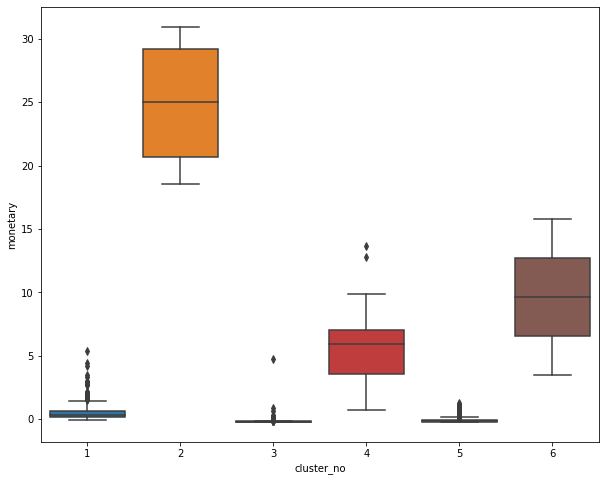

In [395]:
plt.figure(figsize=(10,8))
sns.boxplot(x="cluster_no",y="monetary",data=rfm_scaled_df);

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


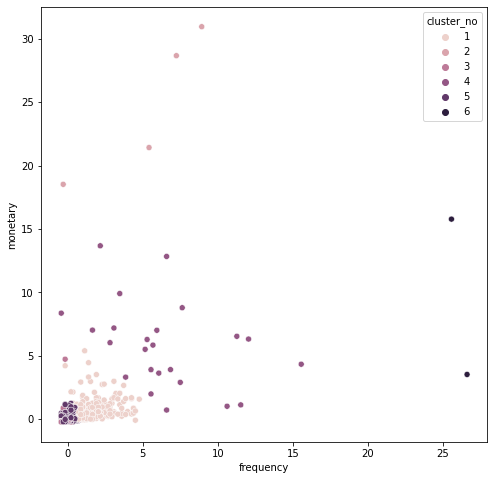

In [396]:
plt.figure(figsize=(8,8))
sns.scatterplot("frequency", "monetary",hue="cluster_no", data=rfm_scaled_df);

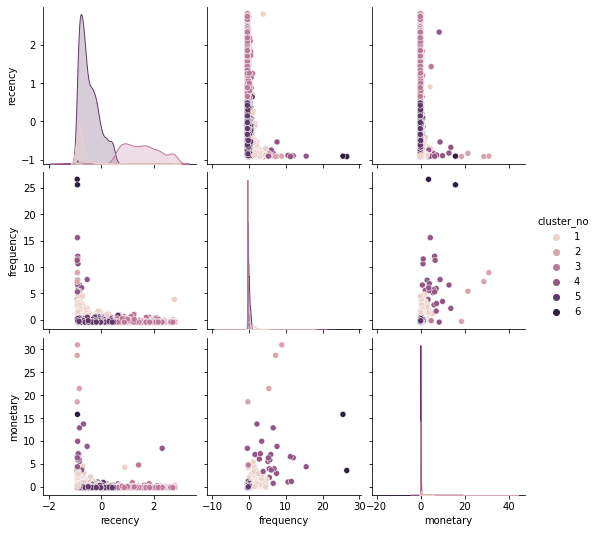

In [398]:
sns.pairplot(rfm_scaled_df, hue='cluster_no')

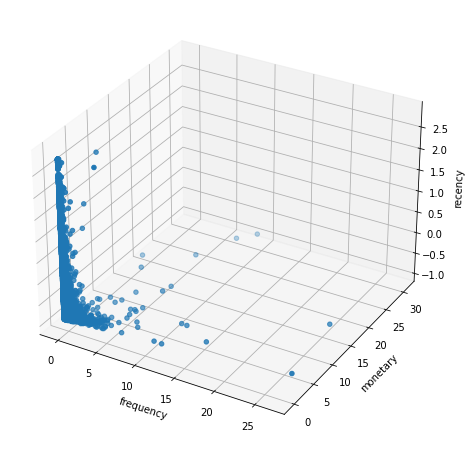

In [399]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')

x = rfm_scaled_df['frequency']
y = rfm_scaled_df['monetary']
z = rfm_scaled_df['recency']

ax.set_xlabel("frequency")
ax.set_ylabel("monetary")
ax.set_zlabel("recency")

ax.scatter(x, y, z)

plt.show()